---
### ZOMBIE PANDEMIC!

IDM modeling demo of a Zombie pandemid using the [Starsim](https://github.com/starsimhub) framework. When Zombies attack, ased on information from the [CDC](https://stacks.cdc.gov/view/cdc/6023) and cutting edge research from resources including [zombieresearchsociety.com](https://zombieresearchsociety.com) and [Zombiepedia](https://zombie.fandom.com).

![CDC Zombies p1](CDC-Zombies-p1.jpg "CDC Zombies p1")


![CDC Zombies p10](CDC-Zombies-p10.jpg "CDC Zombies p10")


![CDC Zombies p21](CDC-Zombies-p21.jpg "CDC Zombies p21")
---

---
### Let's start by importing some basic packages
* **Starsim** is our new agent-based disease modeling framework. [Starsim source code](http://starsim.org) is open source and freely available. See also our emerging [online documentation and tutorials](https://docs.idmod.org/projects/starsim/en/latest/).
* **zombie** is all the stuff we'll need to do zombie simulations
* Other imports are for numerical operations (**numpy**, **pandas**), convenience (**sciris**), and plotting (**seaborn**, **matplotlib**)
---

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import starsim as ss # starsim is the Starsim framwork
from zombie import * # zombie is a custom zombie library, see zombie.py

# Numerical librarires and utilities
import numpy as np
import pandas as pd
import sciris as sc

# Plotting libraries
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
pyplot.rcParams['figure.dpi'] = 120

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
### Basic SIR simulation using the Starsim framework

* We represent the population using 5,000 agents
* 3% are selected at random to be "seed" infections.
* The disease will transmit on a "random" network in the sense that contacts between agents will be recreated on every time step. The number of contacts will be Poisson distributed with a mean of 4.
* The simulation runs in a fraction of a second.
* We then plot some default channels.
---

Initializing sim with 5000 agents
  Running 2000.0 ( 0/51) (0.02 s)  ———————————————————— 2%
  Running 2010.0 (10/51) (0.04 s)  ••••———————————————— 22%
  Running 2020.0 (20/51) (0.07 s)  ••••••••———————————— 41%
  Running 2030.0 (30/51) (0.09 s)  ••••••••••••———————— 61%
  Running 2040.0 (40/51) (0.10 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (0.11 s)  •••••••••••••••••••• 100%



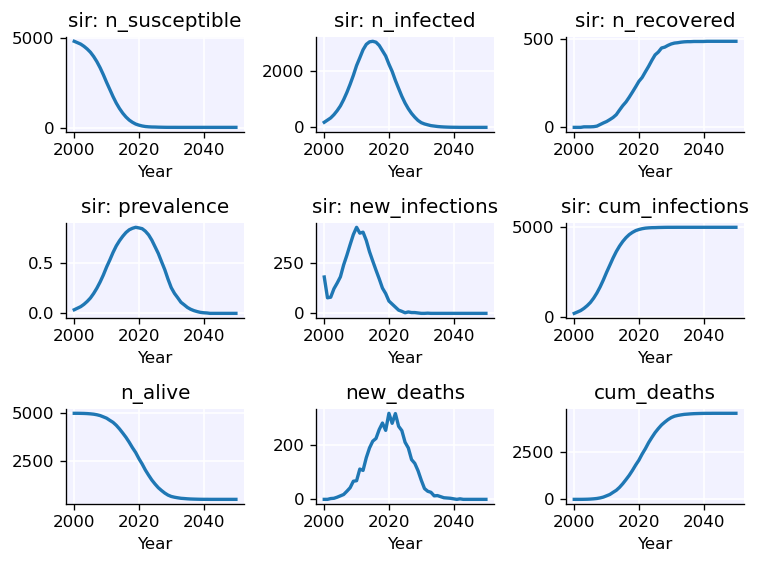

In [16]:
people = ss.People(n_agents=5_000)

sir_pars = dict(
    beta = 0.1,
    init_prev = ss.bernoulli(p=0.03),
    dur_inf = ss.weibull(c=3, scale=10),
    p_death = ss.bernoulli(p=lambda _, sim, uids: sim.people.age[uids]/20),
)
sir = ss.SIR(sir_pars)

network = ss.RandomNet(n_contacts=ss.poisson(lam=4))
sim = ss.Sim(people=people, diseases=sir, networks=network)
sim.run()
sim.plot();

---
### But we want ZOMBIES!!!

**Zombie** is an extension of the SIR disease that adds some important features:
  * **p_fast** is the probability of zombie being fast, choosing 10% here based on my research. Fast zombies more contacts than slow zombies.
  * **dur_fast** is the duration of a zombie being fast before reverting to slow, default 1000 years.
  * **dur_inf** is the duration of zombie infection, default is 1000 years. Once a zombie, always a zombie!
  * **p_symptomatic** is the probability of showing symptoms, default assumption is 100%
  * **p_death_on_zombie_infection** is the probability of death when converting to a zombie, 50% might be a bit high based on my research!

A deep meta-analysis of recent and historical literature reveals that there are at least three ways to become a zombie:
1. Be attacked by a zombie, and survive!
2. Die of natural causes and be transformed into a zombie upon death
3. Acquire zombiism congenitally through pre-natal transmission.

**DeathZombies** is an extension of the base **Deaths** demographic class that captures people at natural death and potentially makes them zombies
  * **p_zombie_on_natural_death** is the probability of becoming a zombie on death due to natural causes

The **Pregnancy** and **MaternalNet** modules work together to simulate pregnancy, forming network connections between mothers and pre-birth children on which disease (zombie) transmission can occur.


We include an intervention, **KillZombies** that kills only *symptomatic* zombies at a rate of 0.5/year.

Configuring and running the simulation from 2024 to 2040 takes less than one second.
Showing built-in plots, although it is easy to generate alternative figures stored in sim.results.

---

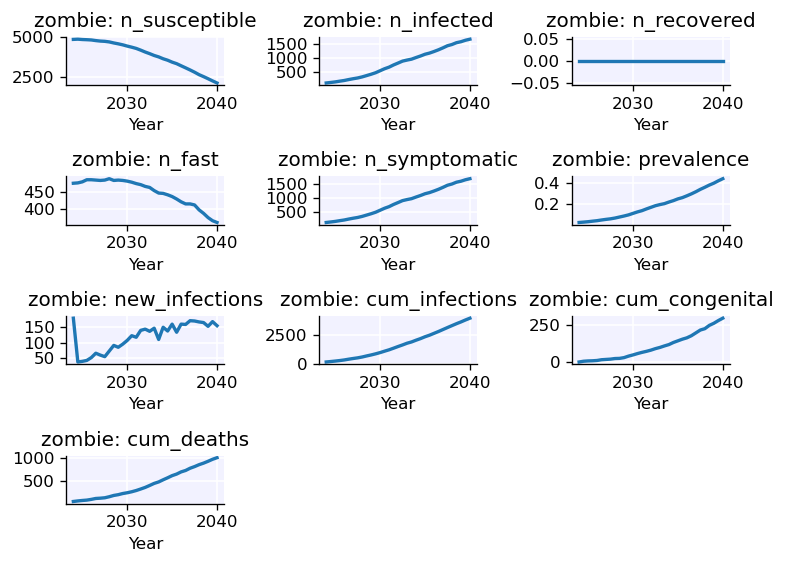

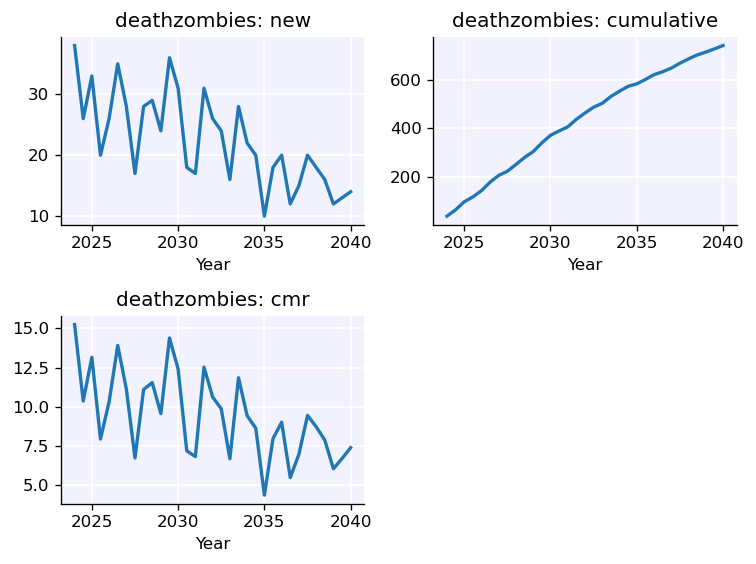

In [17]:
people = ss.People(n_agents=5_000) # People, as before

# Configure and create an instance of the Zombie class
zombie_pars = dict(
    init_prev = 0.03,
    beta = {'random': 0.05, 'maternal': 10},
    p_fast = ss.bernoulli(p=0.1),
    p_death_on_zombie_infection = ss.bernoulli(p=0.25),
    p_symptomatic = ss.bernoulli(p=1.0),
)
zombie = Zombie(zombie_pars)

# This function allows the lambda parameter of the poisson distribution used to determine
# n_contacts to vary based on agent characteristics, a key feature of Starsim.
def choose_degree(self, sim, uids):
    mean_degree = np.full(fill_value=4, shape=len(uids)) # Default value is 4
    is_fast = (sim.diseases['zombie'].infected[uids]) & (sim.diseases['zombie'].fast[uids])
    mean_degree[is_fast] = 50 # Fast zombies get 50
    return mean_degree

# We create two network layers, random and maternal
networks = [
    ss.RandomNet(n_contacts=ss.poisson(lam=choose_degree)),
    ss.MaternalNet()
]

# Configure and create demographic modules
death_pars = dict(
    death_rate = 15, # per 1,000
    p_zombie_on_natural_death = ss.bernoulli(p=0.2),
)
deaths = DeathZombies(**death_pars)
births = ss.Pregnancy(fertility_rate=175) # per 1,000 women 15-49 annually
demog = [births, deaths]

# Create an intervention that kills symptomatic zombies
interventions = KillZombies(year=2024, rate=0.1)

# And finally bring everything together in a sim
sim_pars = dict(start=2024, end=2040, dt=0.5, verbose=0)
sim = ss.Sim(sim_pars, people=people, diseases=zombie, networks=networks, demographics=demog, interventions=interventions)

# Run the sim and plot results
sim.run()
sim.plot('zombie')
sim.plot('deathzombies');

---
# But what do we actually know about zombies?

![ChatCPT](chat.png "ChatGPT Fast Zombies")

Empirical data on Zombies is sparse. Here we compare default assumptions (same as above) to several alternatives:

| | Scenario Name | Configuration |
| --- | --- | --- |
| 0 | Default assumptions| Same as above |
| 1 | More fast zombies| 75% of zombies are fast, as opposed to 25% |
| 2 | Fast-->slow zombies | 75% of zombies start fast, but slow down after about 2y |
| 3 | Shorter infectious period | Zombies remain infectious for about 5y |
| 4 | All zombies asymptomatic | Zombies are asymptomatic (hmm?!) |
| 5 | Less death on zombie infection | 10% die on zombie infection, down from 25% |
| 6 | Half zombie on natural death | 50% of natural deaths transform into a zombie |
| 7 | REALLY BAD | A worst case scenario |
---

### Define the scenarios

In [18]:
scens = {
    'Default assumptions': {},
    'More fast zombies': {'zombie_pars': dict(p_fast=ss.bernoulli(p=0.75))},
    'Fast-->Slow zombies': {'zombie_pars': dict(p_fast=ss.bernoulli(p=0.75), dur_fast=ss.weibull(c=2, scale=2))},
    'Shorter infectious period': {'zombie_pars': dict(dur_inf=ss.normal(loc=5, scale=2))},
    'All zombies asymptomatic': {'zombie_pars': dict(p_symptomatic=ss.bernoulli(p=0))},
    'Less death on zombie infection': {'zombie_pars': dict(p_death_on_zombie_infection=ss.bernoulli(p=0.10))},
    'Half zombie on natural death': {'death_pars': dict(p_zombie_on_natural_death=ss.bernoulli(p=0.5))},
    'REALLY BAD': {'zombie_pars': dict(p_fast=ss.bernoulli(p=1.0), p_symptomatic=ss.bernoulli(p=0), p_death_on_zombie_infection=ss.bernoulli(p=0.50)),
                   'death_pars': dict(p_zombie_on_natural_death=ss.bernoulli(p=1.0))},
}

### Now make a function that configures and runs a zombie simulation, taking inputs from the user.  When the run is complete, results are returned as a dataframe.

In [19]:
def run_zombies(scen, rand_seed, zombie_pars=None, death_pars=None, intvs=[], **kwargs):
    people = ss.People(n_agents=5_000) # People

    # Zombies
    zombie_defaults = dict(
        init_prev = 0.03,
        beta = {'random': 0.05, 'maternal': 10},
        p_fast = ss.bernoulli(p=0.1),
        p_death_on_zombie_infection = ss.bernoulli(p=0.25),
        p_symptomatic = ss.bernoulli(p=1.0),
    )
    zombie_pars = sc.mergedicts(zombie_defaults, zombie_pars) # Override defaults with user-specified parameters
    zombie = Zombie(zombie_pars)

    # Networks
    networks = [
        ss.RandomNet(n_contacts=ss.poisson(lam=choose_degree)),
        ss.MaternalNet()
    ]

    # Deaths
    death_defaults = dict(
        death_rate = 15, # per 1,000 per year
        p_zombie_on_natural_death = ss.bernoulli(p=0.2),
    )
    death_pars = sc.mergedicts(death_defaults, death_pars)
    deaths = DeathZombies(**death_pars)

    # Births
    births = ss.Pregnancy(fertility_rate=175) # per 1,000 women 15-49 per year
    demog = [births, deaths]

    # Interventions
    interventions = KillZombies(year=2024, rate=0.1)
    interventions = [interventions] + sc.promotetolist(intvs) # Add interventions passed in

    # Create and run the simulation
    sim_pars = dict(start=2024, end=2040, dt=0.5, rand_seed=rand_seed, label=scen, verbose=0)
    sim = ss.Sim(sim_pars, people=people, diseases=zombie, networks=networks, demographics=demog, interventions=interventions)
    sim.run()

    # Package results
    df = pd.DataFrame( {
        'Year': sim.yearvec,
        'Population': sim.results.n_alive,
        'Zombies': sim.results.zombie.n_infected,
        'Zombie Prevalence': sim.results.zombie.prevalence,
        'Congential Zombies (cum)': sim.results.zombie.cum_congenital,
        'Zombie-Cause Mortality': sim.results.zombie.cum_deaths,
    })
    df['rand_seed'] = rand_seed
    df['Scen'] = scen
    for key, val in kwargs.items():
        df[key] = val

    return df

### Now run all the scenarios in parallel, repeating each configuration 10 times.

In [20]:
# Now run all the scenarios in parallel, repeating each configuration 10 times
n_repeats = 10

results = []
cfgs = []

for skey, scen in scens.items():
    for rand_seed in range(n_repeats):
        cfgs.append({'scen': skey, 'rand_seed':rand_seed} | scen)

T = sc.tic()
results += sc.parallelize(run_zombies, iterkwargs=cfgs)
print(f'Completed {len(cfgs)} sims in {sc.toc(T, output=True):.1f}s')
df = pd.concat(results).replace(np.inf, np.nan)

# Display the top of the results data frame
display(df.head())

Completed 80 sims in 5.1s


,Year,Population,Zombies,Zombie Prevalence,Congential Zombies (cum),Zombie-Cause Mortality,rand_seed,Scen
0,2024.0,4984.0,139.0,0.027889,2.0,51.0,0,Default assumptions
1,2024.5,4994.0,158.0,0.031638,6.0,62.0,0,Default assumptions
2,2025.0,5010.0,174.0,0.034731,7.0,68.0,0,Default assumptions
3,2025.5,5011.0,198.0,0.039513,10.0,76.0,0,Default assumptions
4,2026.0,5022.0,237.0,0.047192,14.0,95.0,0,Default assumptions


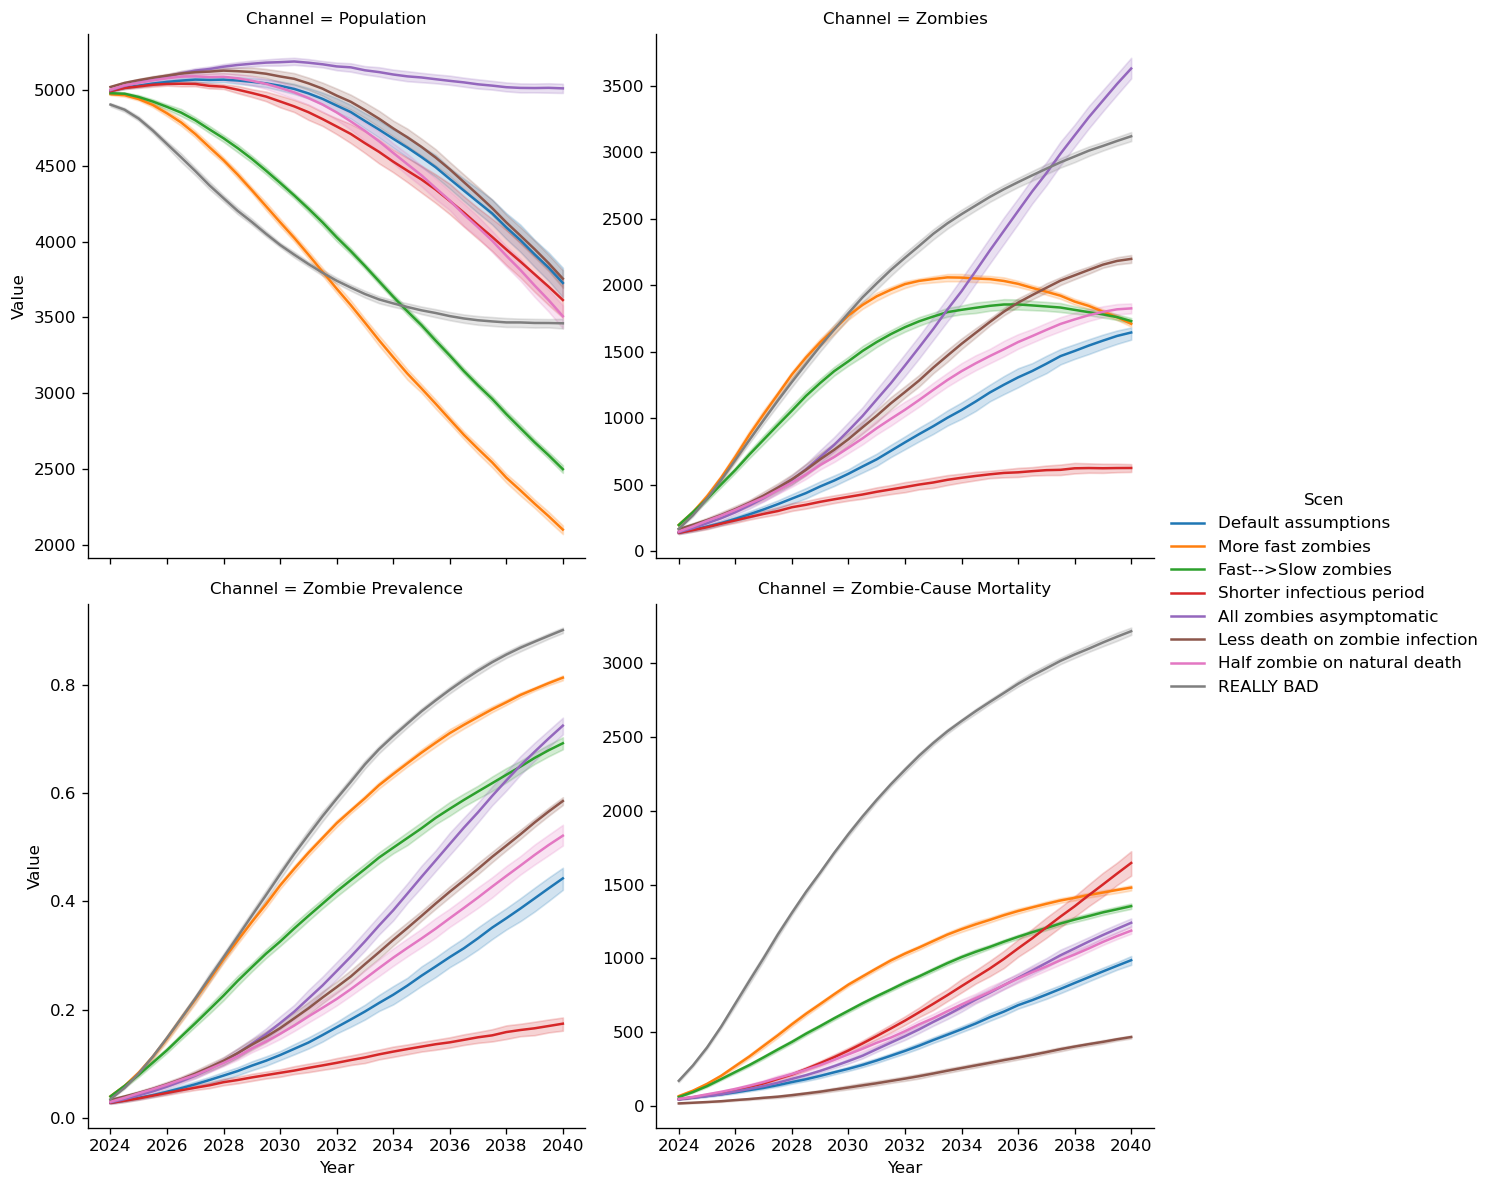

In [21]:
# Manipulate the data and create a plot using the Seaborn library
dfm = df.melt(id_vars=['Scen', 'Year', 'rand_seed'], value_vars=['Population', 'Zombies', 'Zombie Prevalence', 'Zombie-Cause Mortality'], var_name='Channel', value_name='Value')
g = sns.relplot(kind='line', data=dfm, col='Channel', x='Year', y='Value', hue='Scen', facet_kws=dict(sharey=False), col_wrap=2)

---
### That's alarming! What can we do to slow the spread of zombies?


Let's consider a vaccine intervention, and see how well it works in each scenario.

---

In [22]:
# Create a vaccine intervention
antizombie_vx = zombie_vaccine(efficacy = 0.95)
vx_intv = ss.campaign_vx(
    product = antizombie_vx,
    years = [2028],  # Begin year
    prob = [0.6],    # Coverage
)

# Revise scenarios to see impact of the vaccine
scens_vx = {}
for skey, scen in scens.items():
    scens_vx[skey] = scen.copy()
    scens_vx[skey]['intvs'] = [vx_intv]

In [23]:
results = []
cfgs = []

for skey, scen in scens_vx.items():
    for rand_seed in range(n_repeats):
        cfgs.append({'scen': skey,'rand_seed':rand_seed} | scen) # Merge dicts with pipe operators

T = sc.tic()
results += sc.parallelize(run_zombies, iterkwargs=cfgs)
print(f'That took: {sc.toc(T, output=True):.1f}s')
df_vx = pd.concat(results)

# Combine results
df['Vx'] = False
df_vx['Vx'] = True
df_all = pd.concat([df, df_vx])

That took: 5.0s


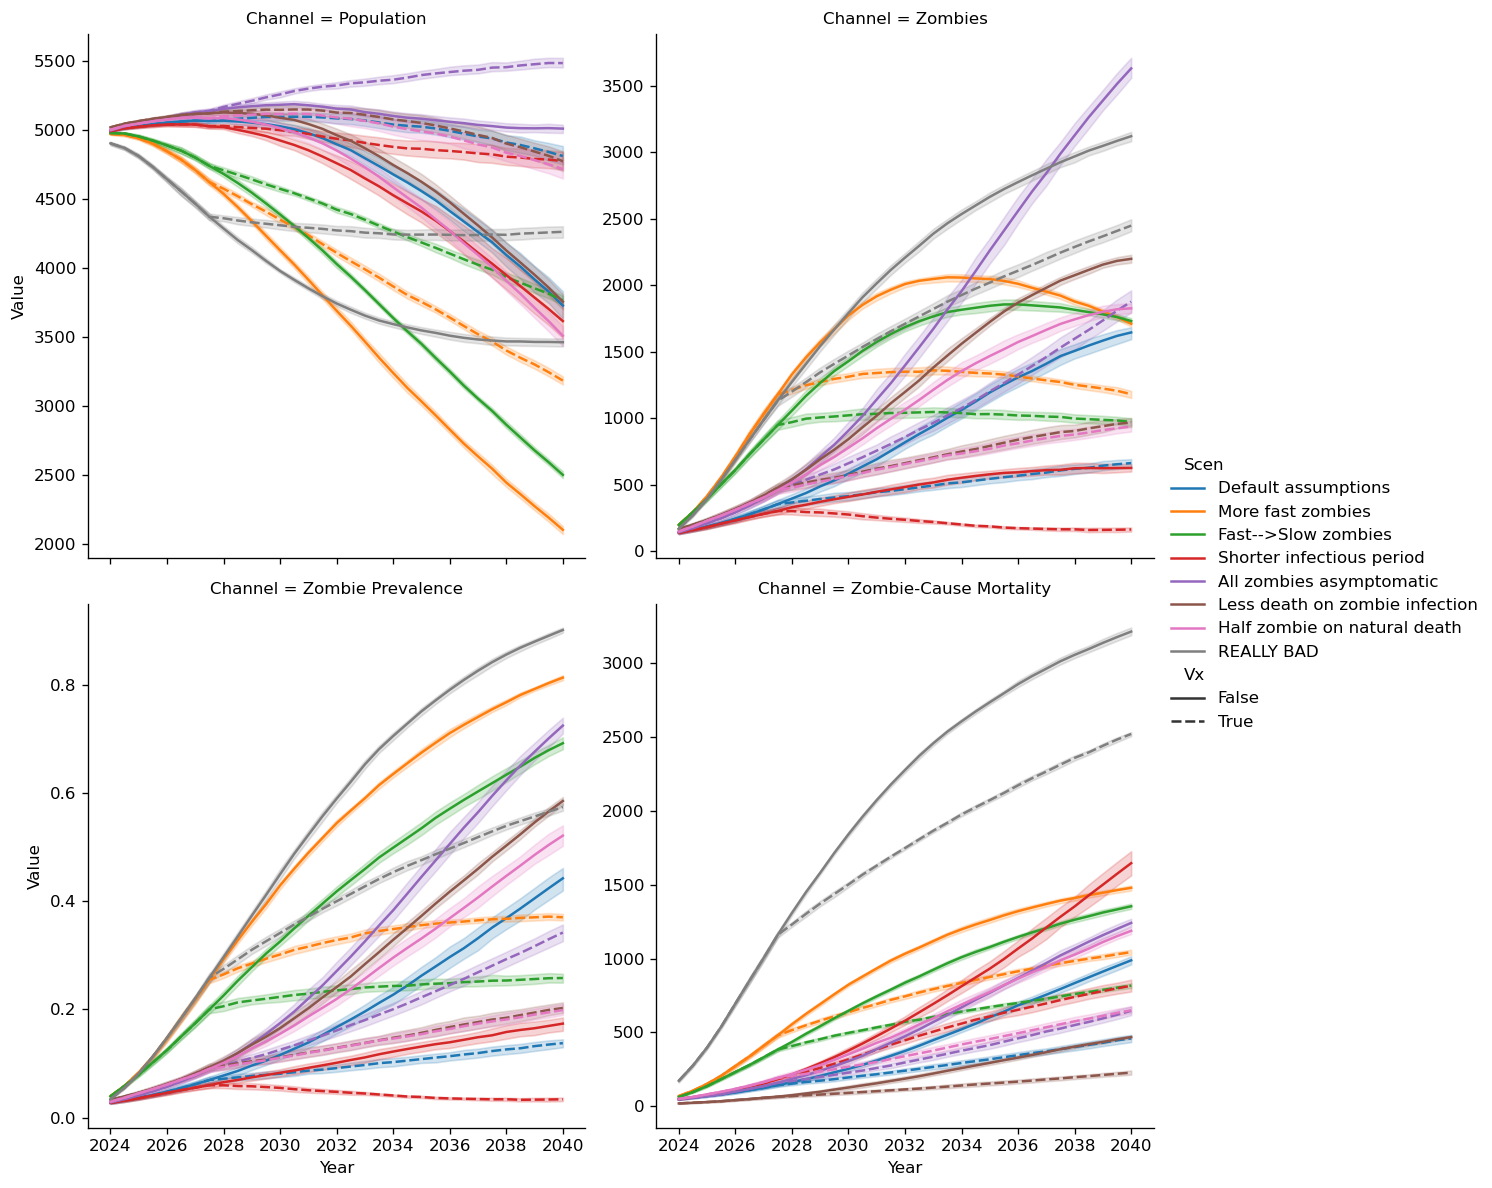

In [24]:
dfm = df_all.melt(id_vars=['Scen', 'Vx', 'Year', 'rand_seed'], value_vars=['Population', 'Zombies', 'Zombie Prevalence', 'Zombie-Cause Mortality'], var_name='Channel', value_name='Value')
g = sns.relplot(kind='line', data=dfm, col='Channel', x='Year', y='Value', hue='Scen', style='Vx', facet_kws=dict(sharey=False), col_wrap=2);

### How many lives are we saving with vaccine?

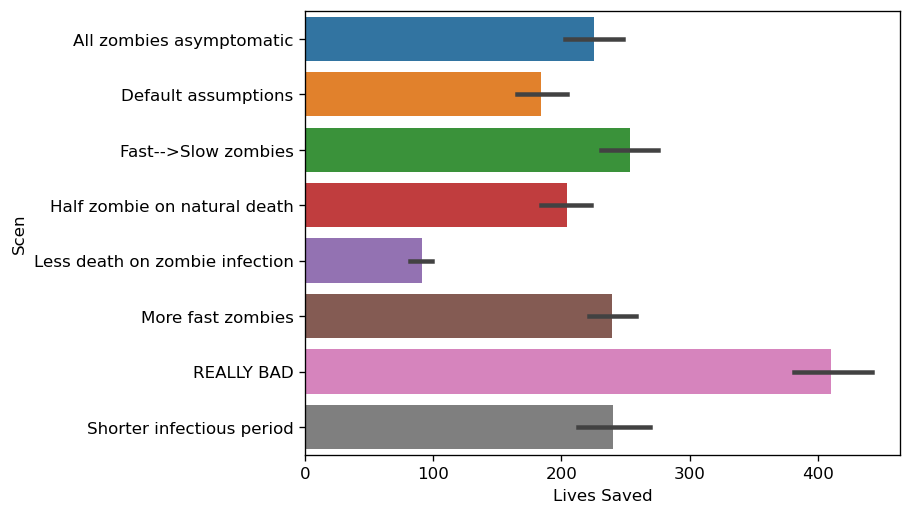

In [25]:
dfp = df_all.pivot(index=['Year', 'Scen', 'rand_seed'], columns='Vx', values='Zombie-Cause Mortality')
dfp['Lives Saved'] = dfp[False] - dfp[True]
g = sns.barplot(data=dfp.reset_index(), x='Lives Saved', y='Scen')

---
### We can also look at multiplie zombie "variants"
* Separate fast and slow zombies in to separate diseases
* Being infected with one gives immunity to the other, using a "connector"
* Main difference is that fast (slow) create new fast (slow) zombies on infection, instead of just random
---

In [26]:
def run_multizombie(rand_seed):
    people = ss.People(n_agents=5_000) # People

    # Start with parameters for slow zombies
    slow_zombie_pars = dict(
        init_prev = 0.03,
        beta = {'random': 0.05, 'maternal': 10},
        p_fast = ss.bernoulli(p=0), # <--- Notice NONE are fast
        p_death_on_zombie_infection = ss.bernoulli(p=0.25),
        p_symptomatic = ss.bernoulli(p=1.0),
    )
    slow_zombie = Zombie(slow_zombie_pars, name='slow_zombie')

    # Now create fast zombies
    fast_zombie_pars = slow_zombie_pars.copy()
    fast_zombie_pars['p_fast'] = ss.bernoulli(p=1) # <-- Notice ALL are fast
    fast_zombie = Zombie(fast_zombie_pars, name='fast_zombie')

    zombies = [fast_zombie, slow_zombie]

    connector = ZombieConnector() # Interaction between slow and fast zombies (full cross protection)

    def choose_degree(self, sim, uids):
        mean_degree = np.full(fill_value=4, shape=len(uids))
        is_fast = ((sim.diseases['fast_zombie'].infected[uids]) & (sim.diseases['fast_zombie'].fast[uids])) | \
                ((sim.diseases['slow_zombie'].infected[uids]) & (sim.diseases['slow_zombie'].fast[uids]))
        mean_degree[is_fast] = 50
        return mean_degree

    networks = [
        ss.RandomNet(n_contacts=ss.poisson(lam=choose_degree)),
        ss.MaternalNet()
    ]

    death_pars = dict(
        death_rate = 15, # per 1,000 per year
        p_zombie_on_natural_death = ss.bernoulli(p=0.2),
    )
    deaths = DeathZombies(**death_pars)
    births = ss.Pregnancy(fertility_rate=175) # per 1,000 women 15-49 per year
    demog = [births, deaths]

    killzombies = KillZombies(year=2024, rate=0.1)

    sim_pars = dict(start=2024, end=2040, dt=0.5, rand_seed=rand_seed, label=scen, verbose=0)
    sim = ss.Sim(sim_pars, people=people, diseases=zombies, networks=networks, demographics=demog, interventions=killzombies, connectors=connector)
    sim.run()

    # Package results by zombie speed
    dfs = []
    for speed in ['Fast', 'Slow']:
        res = sim.results.fast_zombie if speed == 'Fast' else sim.results.slow_zombie
        df = pd.DataFrame( {
            'Year': sim.yearvec,
            'Number of Zombies': res.n_infected,
            'Prevalence': res.prevalence,
            'Zombie-Cause Mortality': res.cum_deaths,
        })
        df['rand_seed'] = rand_seed
        df['Speed'] = speed
        dfs.append(df)

    return pd.concat(dfs)

### Run variant simulations and plot results

In [27]:
T = sc.tic()
results = sc.parallelize(run_multizombie, iterkwargs={'rand_seed':range(n_repeats)} )
print(f'That took: {sc.toc(T, output=True):.1f}s')
df = pd.concat(results)

That took: 0.9s


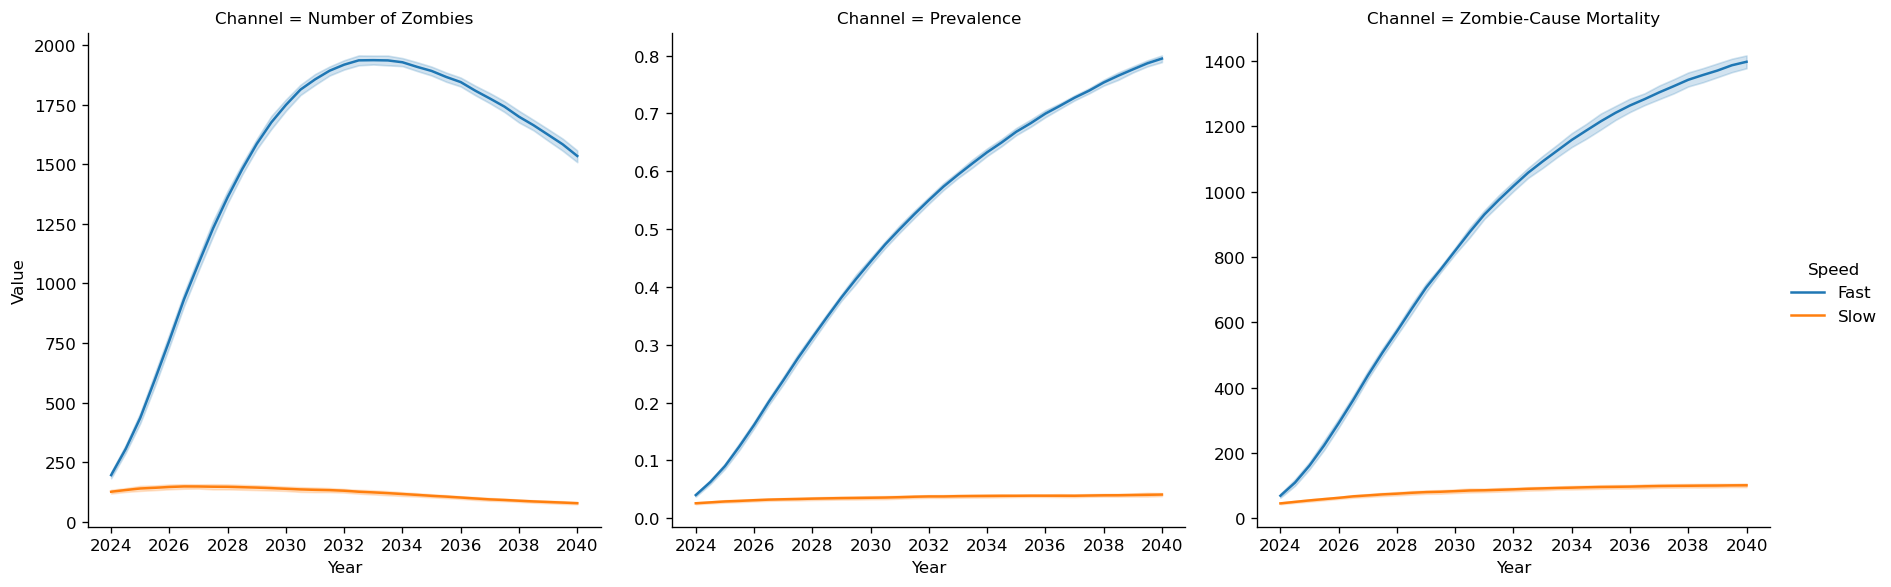

In [28]:
# Manipulate the data and create a plot using the Seaborn library
ch = df.columns.drop(['Year', 'Speed', 'rand_seed'])
dfm = df.melt(id_vars=['Year', 'Speed', 'rand_seed'], value_vars=ch, var_name='Channel', value_name='Value')
g = sns.relplot(kind='line', data=dfm, col='Channel', hue='Speed', x='Year', y='Value', facet_kws=dict(sharey=False))

# Thanks!